# Rainfall Data Acquisition and Processing

 - Download daily CHIRPS Rainfall data from 1981–2024

 - Clip by Uganda 
 
 - Compute areal-weighted monthly mean (use pixel area or cos(lat) weights).

 - Build seasonal totals:
    - OND = Oct+Nov+Dec
    - MAM = Mar+Apr+May

- Climatology & anomalies

  - Define a base pevarianceriod (WMO 1991–2020)

  - Compute seasonal climatology and anomalies: anom = total − clim

  - Standardize: z = (anom / std) to stabilize 

In [ ]:
import os

import os, glob, math, re, io, warnings, requests, yaml
from typing import Dict, Tuple, List

import argparse
from pathlib import Path
import sys, os
import requests

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import regionmask
from shapely.geometry import mapping
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


xr.set_options(keep_attrs=True)

# Set working directory 

os.chdir("C:\\Users\\yonas\\Documents\\ICPAC\\ea_seasonal_pred\\seasonal-ml-pred")

# Paths (matches your repo)
RAW_DIR        = "data/raw"
PROCESSED_DIR  = "data/processed"
EXTERNAL_DIR   = "data/external/indices"
LOGS_DIR       = "reports/logs"

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(EXTERNAL_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

## Download CHIRPS Daily Rainfall Data (1981–2024)

1) Download CHIRPS daily NetCDF (v2.0) by year range
2) Clip to a region
3) Merge all (clipped or raw) files into a single NetCDF 


Source: "https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/"

Spatial resolution: [p25=0.25°, p05=0.05°]

In [12]:
"""
Download CHIRPS daily NetCDF (v2.0) by year range, optionally clip to a region,
and merge all (clipped or raw) files into a single NetCDF saved in.
"""


def download_file(url: str, dest: Path, chunk=2**20):
    dest.parent.mkdir(parents=True, exist_ok=True)
    tmp = dest.with_suffix(dest.suffix + ".part")
    with requests.get(url, stream=True, timeout=180) as r:
        r.raise_for_status()
        with open(tmp, "wb") as f:
            for blk in r.iter_content(chunk_size=chunk):
                if blk: f.write(blk)
    tmp.replace(dest)

def build_url(year: int, res: str) -> str:
    base = f"https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/{res}"
    return f"{base}/chirps-v2.0.{year}.days_{res}.nc"

def standardize_for_merge(ds):
    ren = {}
    if "latitude" in ds.dims: ren["latitude"] = "lat"
    if "longitude" in ds.dims: ren["longitude"] = "lon"
    if ren:
        ds = ds.rename(ren)
    try:
        lat = ds["lat"]
        if lat[0] > lat[-1]:
            ds = ds.reindex(lat=list(reversed(lat.values)))
    except Exception:
        pass
    return ds

def clip_box(ds, N, S, W, E):
    import numpy as np
    
    # Validate latitude bounds
    if S >= N:
        raise ValueError(f"Invalid latitude bounds: South ({S}) must be less than North ({N})")
    
    # Work with original coordinate names first
    lat_name = "latitude" if "latitude" in ds.dims else "lat"
    lon_name = "longitude" if "longitude" in ds.dims else "lon"
    
    lat = ds[lat_name].values
    lon = ds[lon_name].values
    
    # For xarray.sel(), we need to provide bounds in the correct order
    # CHIRPS latitude goes from south to north (-49.875 to 49.875)
    # So we select from S (southern bound) to N (northern bound)
    lat_slice = slice(S, N)
    
    lon_min, lon_max = float(lon.min()), float(lon.max())
    W2, E2 = W, E
    
    # Handle longitude wrapping if needed (CHIRPS uses -180 to 180)
    if lon_min >= 0 and W < 0:  # convert input -180..180 to 0..360, if needed
        W2 = (W + 360) % 360
        E2 = (E + 360) % 360
    
    # Create selection dictionary
    sel_dict = {lat_name: lat_slice}
    
    if W2 <= E2:
        sel_dict[lon_name] = slice(W2, E2)
        ds_sub = ds.sel(sel_dict)
    else:
        # Handle longitude wrapping case
        left_dict = {lat_name: lat_slice, lon_name: slice(W2, lon_max)}
        right_dict = {lat_name: lat_slice, lon_name: slice(lon_min, E2)}
        left = ds.sel(left_dict)
        right = ds.sel(right_dict)
        ds_sub = type(ds).concat([left, right], dim=lon_name)
    
    # Now standardize for merge
    ds_sub = standardize_for_merge(ds_sub)
    return ds_sub

def merge_to_netcdf(nc_paths, out_path: Path):
    import xarray as xr
    if not nc_paths:
        raise ValueError("No input files found to merge.")
    print(f"[merge] {len(nc_paths)} files -> {out_path.name}")
    ds = xr.open_mfdataset(
        [str(p) for p in nc_paths],
        combine="by_coords",
        preprocess=standardize_for_merge,
        parallel=False,
    )
    data_vars = list(ds.data_vars)
    if not data_vars:
        raise ValueError("No data variables in opened datasets.")
    enc = {v: {"zlib": True, "complevel": 3} for v in data_vars}
    out_path.parent.mkdir(parents=True, exist_ok=True)
    ds.to_netcdf(out_path, encoding=enc)
    print("[ok] merged saved:", out_path)

def main():
    ap = argparse.ArgumentParser(description="Download CHIRPS daily v2.0 by year range; optional clip & merge (merged saved in --outdir).")
    ap.add_argument("--start", type=int, required=True, help="Start year (e.g., 2018)")
    ap.add_argument("--end", type=int, required=True, help="End year (inclusive, e.g., 2020)")
    ap.add_argument("--outdir", default="chirps_downloads", help="Directory to save yearly and merged files")
    ap.add_argument("--res", choices=["p25","p05"], default="p25", help="Spatial resolution: p25=0.25°, p05=0.05°")
    ap.add_argument("--clip", nargs=4, type=float, metavar=("N","S","W","E"),
                    help="Optional clip box (degrees): North South West East")
    ap.add_argument("--merge-name", type=str, default=None,
                    help="Merged filename (no path). If omitted, an automatic name is used.")
    ap.add_argument("--overwrite", action="store_true", help="Overwrite existing yearly files")
    args = ap.parse_args()

    years = list(range(args.start, args.end + 1))
    outdir = Path(args.outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    downloaded = []
    clipped = []

    for y in years:
        url = build_url(y, args.res)
        raw_nc = outdir / f"chirps-v2.0.{y}.days_{args.res}.nc"
        if not raw_nc.exists() or args.overwrite:
            print(f"[GET]  {url}")
            try:
                download_file(url, raw_nc)
                print(f"[ok ]  saved {raw_nc}")
            except Exception as e:
                print(f"[ERR]  download failed for {y}: {e}")
                continue
        else:
            print(f"[skip] {raw_nc} exists")
        downloaded.append(raw_nc)

        if args.clip:
            N, S, W, E = args.clip
            out_clip = raw_nc.with_name(raw_nc.stem + "_clip.nc")
            if not out_clip.exists() or args.overwrite:
                try:
                    import xarray as xr
                    ds = xr.open_dataset(raw_nc)
                    ds_sub = clip_box(ds, N, S, W, E)
                    enc = {v: {"zlib": True, "complevel": 3} for v in ds_sub.data_vars}
                    ds_sub.to_netcdf(out_clip, encoding=enc)
                    print(f"[ok ]  clipped → {out_clip}")
                except Exception as e:
                    print(f"[warn] clip failed for {y} ({e}); skipping clip")
            else:
                print(f"[skip] {out_clip} exists")
            if out_clip.exists():
                clipped.append(out_clip)

    # Make merged filename inside outdir
    if args.merge_name:
        merge_name = Path(args.merge_name).name  # drop any directory parts
    else:
        suffix = "_clip" if args.clip else ""
        merge_name = f"chirps_{args.res}_{years[0]}-{years[-1]}{suffix}.nc"
    target = outdir / merge_name

    # Merge if we have files
    to_merge = clipped if args.clip else downloaded
    to_merge = [p for p in to_merge if p.exists()]

    if to_merge:
        try:
            merge_to_netcdf(to_merge, target)
        except Exception as e:
            print(f"[ERR] merge failed: {e}")
            sys.exit(2)
    else:
        print("[warn] nothing to merge (no downloaded or clipped files).")

# if __name__ == "__main__":
#     main()


In [13]:
ug_chirps81_25  = xr.open_dataset(RAW_DIR + "/chirps_p25_uganda/chirps_p25_1981-2024_clip.nc")
ug_chirps81_25 

<xarray.Dataset> Size: 58MB
Dimensions:  (time: 16071, lat: 29, lon: 31)
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-01-01 1981-01-02 ... 2024-12-31
  * lat      (lat) float32 116B -2.375 -2.125 -1.875 ... 4.125 4.375 4.625
  * lon      (lon) float32 124B 28.62 28.88 29.12 29.38 ... 35.62 35.88 36.12
Data variables:
    precip   (time, lat, lon) float32 58MB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-10-07
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

### Mean Annual Total Rainfall Map

In [14]:
 # annual total
pr_ann_sum  = ug_chirps81_25['precip'].resample(time="YS").sum()  

# Then climatological mean (mm/year)
mean_annual = pr_ann_sum.mean("time")       # (lat, lon)

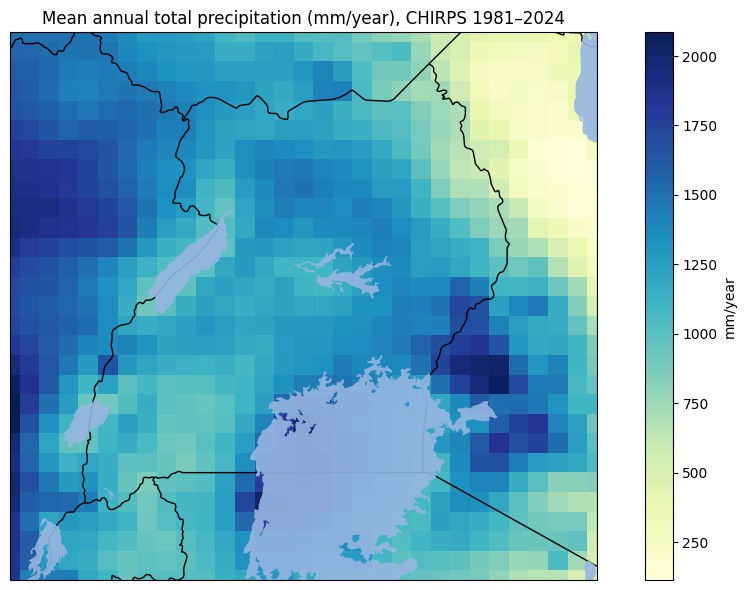

In [15]:
# Plot with Cartopy
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add data
im = mean_annual.plot.imshow(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="YlGnBu",
    add_colorbar=True,
    cbar_kwargs={"label": "mm/year"}
)

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle="-")
ax.add_feature(cfeature.LAKES, alpha=0.9)
#ax.add_feature(cfeature.RIVERS)

# Set title and labels
ax.set_title("Mean annual total precipitation (mm/year), CHIRPS 1981–2024")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Set extent (optional, adjust as needed)
ax.set_extent([mean_annual.lon.min(), mean_annual.lon.max(), mean_annual.lat.min(), mean_annual.lat.max()], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

### Monthly Totals

In [ ]:
# MONTHLY total
pr_mon_sum  = ug_chirps81_25['precip'].resample(time="MS").sum()   # monthly total (mm)

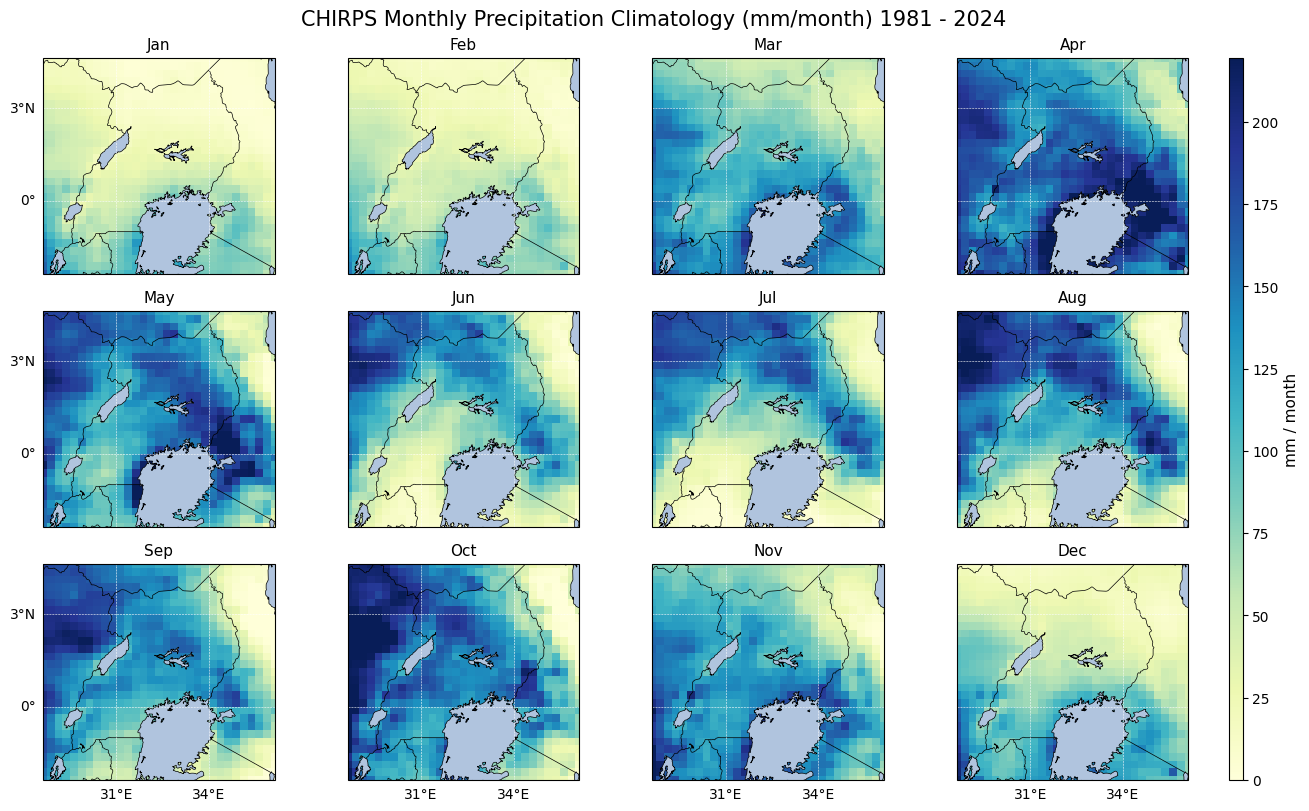

In [18]:
mon_clim = pr_mon_sum.groupby("time.month").mean("time")   # (month, lat, lon)

# --- plotting config
proj = ccrs.PlateCarree()
extent = [float(mon_clim.lon.min()), float(mon_clim.lon.max()),
          float(mon_clim.lat.min()), float(mon_clim.lat.max())]
lon2d, lat2d = np.meshgrid(mon_clim.lon, mon_clim.lat)

# shared color scale
vmin, vmax = 0.0, float(mon_clim.quantile(0.98).values)  # or set vmax=400
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = "YlGnBu"

# layout: 3x4 panels + 1 slim colorbar column
fig = plt.figure(figsize=(13, 8), constrained_layout=True)
gs  = fig.add_gridspec(nrows=3, ncols=5, width_ratios=[1,1,1,1,0.045])

axes = [fig.add_subplot(gs[r, c], projection=proj) for r in range(3) for c in range(4)]
cax  = fig.add_subplot(gs[:, 4])

month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

def style_axis(ax, left=False, bottom=False):
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="0.2", facecolor="navy")
    ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor="black", facecolor="lightsteelblue", linewidth=0.5)
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.set_extent(extent, crs=proj)

    # --- THIS is the important change ---
    gl = ax.gridlines(crs=proj, draw_labels=True,
                      linewidth=0.4, color="white", linestyle="--",
                      x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = left
    gl.bottom_labels = bottom
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    # set locators AFTER creating gridliner
    gl.xlocator = mticker.FixedLocator(np.arange(np.floor(extent[0]), np.ceil(extent[1])+1, 3))
    gl.ylocator = mticker.FixedLocator(np.arange(np.floor(extent[2]), np.ceil(extent[3])+1, 3))

mappables = []
for i, ax in enumerate(axes):
    month = i + 1
    da = mon_clim.sel(month=month)
    im = ax.pcolormesh(lon2d, lat2d, da.values, transform=proj,
                       cmap=cmap, norm=norm, shading="auto")
    ax.set_title(month_labels[i], fontsize=11, pad=6)
    style_axis(ax, left=(i % 4 == 0), bottom=(i // 4 == 2))
    mappables.append(im)

# single colorbar with units
cb = fig.colorbar(mappables[0], cax=cax)
cb.set_label("mm / month", fontsize=11)

fig.suptitle("CHIRPS Monthly Precipitation Climatology (mm/month) 1981 - 2024", fontsize=15)
plt.show()

In [19]:
def _std_dims(ds: xr.Dataset) -> xr.Dataset:
    rename = {}
    if "latitude" in ds.dims: rename["latitude"] = "lat"
    if "longitude" in ds.dims: rename["longitude"] = "lon"
    if rename:
        ds = ds.rename(rename)
    # shift lon to [-180,180] if needed
    if float(ds.lon.max()) > 180:
        ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby("lon")
    return ds

def _get_varname(ds: xr.Dataset) -> str:
    for cand in ["precip", "precipitation", "pr", "rain"]:
        if cand in ds.data_vars:
            return cand
    return list(ds.data_vars)[0]

In [20]:
ds = _std_dims(ug_chirps81_25)
ds

<xarray.Dataset> Size: 58MB
Dimensions:  (time: 16071, lat: 29, lon: 31)
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-01-01 1981-01-02 ... 2024-12-31
  * lat      (lat) float32 116B -2.375 -2.125 -1.875 ... 4.125 4.375 4.625
  * lon      (lon) float32 124B 28.62 28.88 29.12 29.38 ... 35.62 35.88 36.12
Data variables:
    precip   (time, lat, lon) float32 58MB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-10-07
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [21]:
var = _get_varname(ds)
var

'precip'

In [22]:

def uganda_polygon(crs: str = "EPSG:4326") -> gpd.GeoDataFrame:
    """
    Return Uganda admin-0 polygon in requested CRS.
    Tries Cartopy Natural Earth; falls back to NACIS CDN zip.
    """
    world = None
    try:
        import cartopy.io.shapereader as shpreader
        shpfile = shpreader.natural_earth(resolution="110m", category="cultural", name="admin_0_countries")
        world = gpd.read_file(shpfile).to_crs(crs)
    except Exception:
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        world = gpd.read_file(url).to_crs(crs)

    # match by any of the typical name fields
    name_fields = [c for c in ["ADMIN", "SOVEREIGNT", "NAME", "NAME_LONG"] if c in world.columns]
    if not name_fields:
        raise RuntimeError("No country name fields in Natural Earth schema.")
    mask = None
    for col in name_fields:
        m = world[col].str.casefold() == "uganda"
        mask = m if mask is None else (mask | m)
    ug = world.loc[mask].copy()
    if ug.empty:
        raise RuntimeError("Uganda polygon not found.")
    return ug

In [23]:
def ensure_lon_minus180_180(ds: xr.Dataset, lon_name: str = "lon") -> xr.Dataset:
    """Shift lon from [0,360) to [-180,180) if needed."""
    if float(ds[lon_name].max()) > 180:
        ds = ds.assign_coords({lon_name: (((ds[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return ds

def uganda_mask(ds: xr.Dataset, uganda_gdf: gpd.GeoDataFrame,
                lat_name: str = "lat", lon_name: str = "lon") -> xr.DataArray:
    """
    Build a boolean mask (lat, lon) marking cells inside Uganda.
    Uses regionmask.from_geopandas to avoid outline-shape errors.
    """
    # 1) make sure lon ranges are compatible with Natural Earth (-180..180)
    ds = ensure_lon_minus180_180(ds, lon_name=lon_name)

    # 2) dissolve to a single (Multi)Polygon and fix minor topology issues
    gdf = uganda_gdf.to_crs("EPSG:4326").copy()
    gdf = gdf.dissolve()  # merge multipart shapes into one row
    gdf = gdf.reset_index(drop=True)
    # buffer(0) fixes self-intersections if present
    gdf["geometry"] = gdf.buffer(0)

    # 3) regionmask directly from GeoDataFrame
    gdf["name"] = "Uganda"
    regs = regionmask.from_geopandas(gdf[["name", "geometry"]], names="name", name="admin0")

    # 4) mask on ds grid: inside=0, outside=NaN -> convert to boolean
    rm = regs.mask(ds, lon_name=lon_name, lat_name=lat_name)  # DataArray (lat, lon)
    inside = rm.notnull()
    inside.name = "uganda_mask"
    return inside

In [24]:
uga = uganda_polygon()
uga

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
168,Admin-0 country,1,3,Uganda,UGA,0,2,Sovereign country,1,Uganda,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 31.86617 -1.02736, 3..."


In [25]:
def ensure_lon_minus180_180(ds: xr.Dataset, lon_name: str = "lon") -> xr.Dataset:
    """Shift longitudes from [0,360) → [-180,180) if needed."""
    if float(ds[lon_name].max()) > 180:
        ds = ds.assign_coords({lon_name: (((ds[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return ds

def uganda_mask(
    ds: xr.Dataset,
    uganda_gdf: gpd.GeoDataFrame,
    lat_name: str = "lat",
    lon_name: str = "lon",
) -> xr.DataArray:
    """
    Boolean mask (lat, lon) for cells inside Uganda.
    Handles regionmask versions with/without lon_name/lat_name arguments.
    """
    # 1) Ensure lon in [-180, 180]
    ds = ensure_lon_minus180_180(ds, lon_name=lon_name)

    # 2) Single clean (Multi)Polygon
    gdf = uganda_gdf.to_crs("EPSG:4326").copy()
    gdf = gdf.dissolve().reset_index(drop=True)
    gdf["geometry"] = gdf.buffer(0)  # fix tiny topology issues
    gdf["name"] = "Uganda"

    # 3) Build regions and mask
    regs = regionmask.from_geopandas(gdf[["name", "geometry"]], names="name", name="admin0")

    try:
        # Newer regionmask: supports lon_name/lat_name with Dataset
        rm = regs.mask(ds, lon_name=lon_name, lat_name=lat_name)
    except TypeError:
        # Older regionmask: pass arrays/coords directly
        lon = ds[lon_name]
        lat = ds[lat_name]
        rm = regs.mask(lon, lat)  # returns a NumPy array or DataArray depending on version

        # If it's NumPy, wrap into DataArray
        if not isinstance(rm, xr.DataArray):
            # dims from coords
            lat_dim = lat.dims[0]
            lon_dim = lon.dims[0]
            rm = xr.DataArray(rm, coords={lat_dim: lat, lon_dim: lon}, dims=(lat_dim, lon_dim))

    # regionmask returns region numbers inside, NaN outside → convert to boolean
    inside = rm.notnull()
    inside.name = "uganda_mask"
    return inside


In [26]:
mask = uganda_mask(ds, uga)
print(mask.shape, mask.dtype, mask.name)

(29, 31) bool uganda_mask


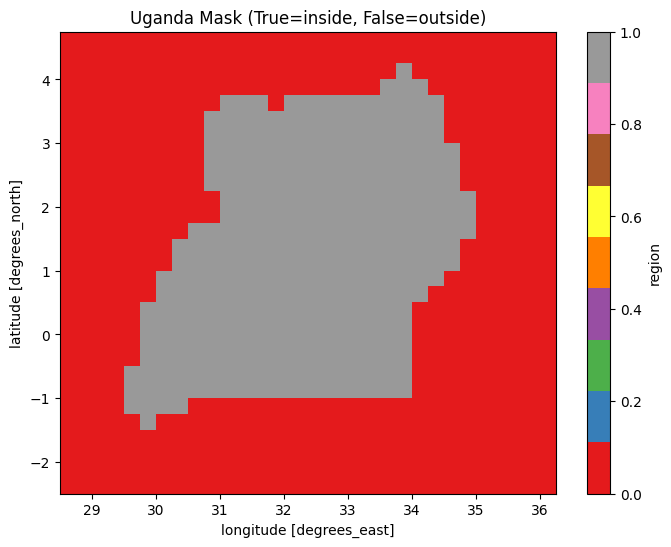

In [27]:
# plot uganda_mask 
plt.figure(figsize=(8, 6))
mask.plot(cmap="Set1")
plt.title("Uganda Mask (True=inside, False=outside)")
plt.show()

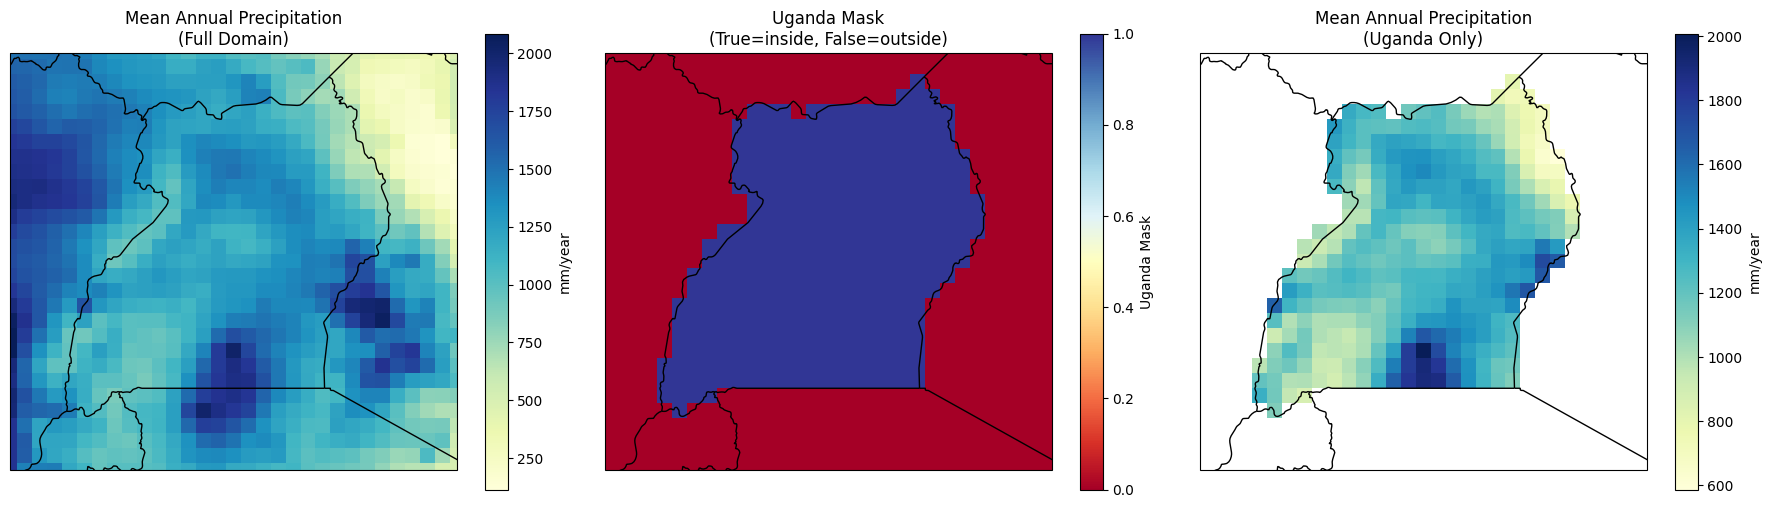

Grid cells in Uganda: 325


In [28]:
# Plot the data within the mask 

# Create subplots for comparison - 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# 1. Original mean annual precipitation (Full Domain)
ax1 = axes[0]
mean_annual.plot.imshow(
    ax=ax1, transform=ccrs.PlateCarree(), cmap="YlGnBu",
    add_colorbar=True, cbar_kwargs={"label": "mm/year", "shrink": 0.8}
)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle="-")
ax1.set_title("Mean Annual Precipitation\n(Full Domain)", fontsize=12)
ax1.set_extent([ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()], crs=ccrs.PlateCarree())

# 2. Uganda mask
ax2 = axes[1]
mask.plot.imshow(ax=ax2, transform=ccrs.PlateCarree(), cmap="RdYlBu", 
                 add_colorbar=True, cbar_kwargs={"label": "Uganda Mask", "shrink": 0.8})
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle="-")
ax2.set_title("Uganda Mask\n(True=inside, False=outside)", fontsize=12)
ax2.set_extent([ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()], crs=ccrs.PlateCarree())

# 3. Masked precipitation (Uganda only)
masked_precip = mean_annual.where(mask)
ax3 = axes[2]
masked_precip.plot.imshow(
    ax=ax3, transform=ccrs.PlateCarree(), cmap="YlGnBu",
    add_colorbar=True, cbar_kwargs={"label": "mm/year", "shrink": 0.8}
)
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle="-")
ax3.set_title("Mean Annual Precipitation\n(Uganda Only)", fontsize=12)
ax3.set_extent([ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Grid cells in Uganda: {mask.sum().values}")

In [29]:
def area_weights(lat: xr.DataArray) -> xr.DataArray:
    return xr.DataArray(np.cos(np.deg2rad(lat)), coords={"lat": lat}, dims=["lat"])

def uganda_area_mean_monthly(ds: xr.Dataset, var: str, mask: xr.DataArray) -> pd.Series:
    w_lat = area_weights(ds["lat"])
    w2d = w_lat.broadcast_like(mask)
    eff_w = (w2d.where(mask, 0.0))
    eff_w = eff_w / eff_w.sum(("lat", "lon"))
    monthly = (ds[var] * eff_w).sum(("lat", "lon"))
    s = monthly.to_series().sort_index()
    s.name = "rf_mm"
    s.index.name = "time"
    return s

In [30]:
monthly_mean = uganda_area_mean_monthly(ds, var, mask)
monthly_mean.head()

time
1981-01-01    0.037048
1981-01-02    5.032150
1981-01-03    4.807163
1981-01-04    2.047453
1981-01-05    1.046977
Name: rf_mm, dtype: float32

In [31]:
monthly_path = os.path.join(PROCESSED_DIR, "uganda_monthly_chirps_1981_2024.csv")
monthly_mean.to_csv(monthly_path)

## Build Seasonal Totals:
- OND = Oct+Nov+Dec
- MAM = Mar+Apr+May

In [32]:
def monthly_to_seasonal_total(monthly: pd.Series, season: str) -> pd.Series:
    if season == "OND":
        months = [10, 11, 12]
    elif season == "MAM":
        months = [3, 4, 5]
    else:
        raise ValueError("season must be 'OND' or 'MAM'")
    df = monthly.to_frame("rf").dropna()
    df["year"] = df.index.year
    df["mon"]  = df.index.month
    sel = df[df["mon"].isin(months)]
    tot = sel.groupby("year")["rf"].sum()
    tot.index.name = "season_year"
    return tot

ond = monthly_to_seasonal_total(monthly_mean, "OND")
mam = monthly_to_seasonal_total(monthly_mean, "MAM")

ond_df = ond.to_frame("OND_total_mm")
mam_df = mam.to_frame("MAM_total_mm")

ond_path_csv = os.path.join(PROCESSED_DIR, "kenya_OND_1981_2024.csv")
mam_path_csv = os.path.join(PROCESSED_DIR, "kenya_MAM_1981_2024.csv")
ond_df.to_csv(ond_path_csv)
mam_df.to_csv(mam_path_csv)

ond_df.head(), mam_df.head()

(             OND_total_mm
 season_year              
 1981           251.316055
 1982           373.333588
 1983           269.184723
 1984           294.980530
 1985           262.542297,
              MAM_total_mm
 season_year              
 1981           459.408356
 1982           435.969727
 1983           354.696686
 1984           312.646851
 1985           479.866699)

## Calculate Climatology (1991–2020),  Anomaly (mm), & Standardized Anomally


- Climatology & anomalies

  - Define a base period (WMO 1991–2020)

  - Compute seasonal climatology and anomalies: anom = total − clim

  - Standardize: z = (anom / std) to stabilize variance

In [33]:
def climatology_and_anoms(seasonal: pd.Series, base: Tuple[int,int]):
    base_mask = (seasonal.index >= base[0]) & (seasonal.index <= base[1])
    clim_mean = seasonal[base_mask].mean()
    clim_std  = seasonal[base_mask].std(ddof=1)
    anom_mm   = seasonal - clim_mean
    anom_std  = (seasonal - clim_mean) / clim_std if clim_std and not math.isclose(clim_std, 0.0) else pd.Series(np.nan, index=seasonal.index)
    # broadcast clim to all years (useful for adding back later)
    clim_series = pd.Series(clim_mean, index=seasonal.index)
    return clim_series, anom_mm, anom_std

In [34]:
START_YEAR, END_YEAR = 1981, 2024
CLIM_START, CLIM_END = 1991, 2020

In [35]:
ond_clim, ond_anom_mm, ond_anom_std = climatology_and_anoms(ond, (CLIM_START, CLIM_END))
mam_clim, mam_anom_mm, mam_anom_std = climatology_and_anoms(mam, (CLIM_START, CLIM_END))

In [36]:
OND_out = pd.DataFrame({
    "season_year": ond.index,
    "OND_total_mm": ond.values,
    "OND_clim1991_2020_mm": ond_clim.values,
    "OND_anom_mm": ond_anom_mm.values,
    "OND_anom_std": ond_anom_std.values
}).set_index("season_year")

MAM_out = pd.DataFrame({
    "season_year": mam.index,
    "MAM_total_mm": mam.values,
    "MAM_clim1991_2020_mm": mam_clim.values,
    "MAM_anom_mm": mam_anom_mm.values,
    "MAM_anom_std": mam_anom_std.values
}).set_index("season_year")

In [37]:
OND_out.head()

,OND_total_mm,OND_clim1991_2020_mm,OND_anom_mm,OND_anom_std
season_year,,,,
1981,251.316055,328.404297,-77.088242,-1.053309
1982,373.333588,328.404297,44.929291,0.613899
1983,269.184723,328.404297,-59.219574,-0.809157
1984,294.980530,328.404297,-33.423767,-0.456691
1985,262.542297,328.404297,-65.862000,-0.899917


In [38]:
MAM_out.head()

,MAM_total_mm,MAM_clim1991_2020_mm,MAM_anom_mm,MAM_anom_std
season_year,,,,
1981,459.408356,416.463226,42.945129,0.838471
1982,435.969727,416.463226,19.506500,0.380850
1983,354.696686,416.463226,-61.766541,-1.205945
1984,312.646851,416.463226,-103.816376,-2.026936
1985,479.866699,416.463226,63.403473,1.237905


In [47]:
OND_out.to_csv(os.path.join(PROCESSED_DIR, "uganda_OND_1981_2024.csv"))         
MAM_out.to_csv(os.path.join(PROCESSED_DIR, "uganda_MAM_1981_2024.csv"))

In [48]:
def missing_report(df: pd.DataFrame, title: str = ""):
    col_na = df.isna().sum().sort_values(ascending=False)
    col_rate = (df.isna().mean()*100).round(1).sort_values(ascending=False)
    row_na = df.isna().sum(axis=1)
    row_rate = (df.isna().mean(axis=1)*100).round(1)
    print(f"=== Missingness report: {title} ===")
    print(f"Rows: {len(df)} | Cols: {df.shape[1]}")
    print(f"Rows with ≥1 missing: {int((row_na>0).sum())} ({(row_na>0).mean()*100:.1f}%)")
    print("\nTop 10 columns by % missing:")
    display(col_rate.head(10).to_frame("% missing"))
    print("\nYears with any missing (first 10):")
    display(row_rate[row_rate>0].head(10).to_frame("% missing in row"))

In [49]:
missing_report(OND_out, "OND 1981-2024")

=== Missingness report: OND 1981-2024 ===
Rows: 44 | Cols: 4
Rows with ≥1 missing: 0 (0.0%)

Top 10 columns by % missing:


,% missing
OND_total_mm,0.0
OND_clim1991_2020_mm,0.0
OND_anom_mm,0.0
OND_anom_std,0.0



Years with any missing (first 10):


,% missing in row
season_year,


In [50]:
missing_report(MAM_out, "MAM 1981-2024")

=== Missingness report: MAM 1981-2024 ===
Rows: 44 | Cols: 4
Rows with ≥1 missing: 0 (0.0%)

Top 10 columns by % missing:


,% missing
MAM_total_mm,0.0
MAM_clim1991_2020_mm,0.0
MAM_anom_mm,0.0
MAM_anom_std,0.0



Years with any missing (first 10):


,% missing in row
season_year,


In [51]:
def plot_missingness(df: pd.DataFrame, title: str):
    m = df.isna().astype(int)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.imshow(m.values, aspect="auto", interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("features")
    ax.set_ylabel("season_year (row)")
    ax.set_yticks([]); ax.set_xticks([])
    plt.show()

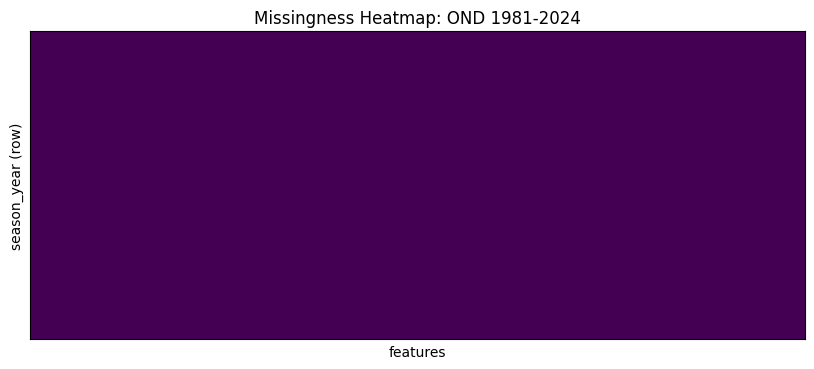

In [52]:
plot_missingness(OND_out, "Missingness Heatmap: OND 1981-2024")

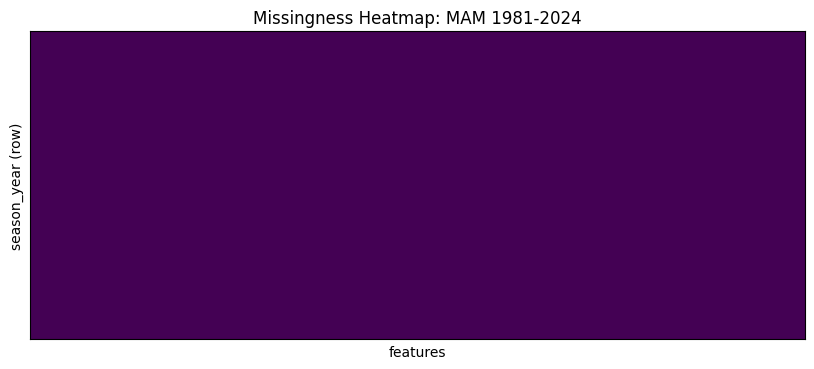

In [46]:
plot_missingness(MAM_out, "Missingness Heatmap: MAM 1981-2024")